In [4]:
import os
import numpy as np
import json
from skimage.draw import polygon
from PIL import Image
import matplotlib.pyplot as plt
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time
import copy
from torchvision.io import read_image
from torchmetrics import Dice
import cv2

In [12]:
import json

with open('train.json', 'r') as f:
    data = json.load(f)

KeyboardInterrupt: 

In [ ]:
root = '/Users/menelaos/Desktop/U-Nets'
image_dir = r'/Users/menelaos/Desktop/U-Nets/images/livecell_train_val_images'

### Process the masks based on .json file

In [ ]:
# Get name of each image
image_name_list = []
files = os.listdir(image_dir)
for file in files:
    name, extension = os.path.splitext(file)
    if extension == '.tif':
        image_name_list.append(name)

In [ ]:
image_dir = '/Users/menelaos/Desktop/U-Nets/dataset/train_masks/'
image_dir1 = '/Users/menelaos/Desktop/U-Nets/dataset/train_images/'
files = os.listdir(image_dir)
files1 = os.listdir(image_dir1)
for file in files:
    name, extension = os.path.splitext(file)
    if not name.startswith('A172'):
        os.remove(image_dir+file)




A172_Phase_B7_1_00d04h00m_3.png
A172_Phase_A7_2_01d00h00m_1.png
A172_Phase_B7_2_00d00h00m_2.png
A172_Phase_B7_1_00d16h00m_4.png
A172_Phase_D7_1_02d12h00m_1.png
A172_Phase_B7_1_02d20h00m_2.png
A172_Phase_D7_1_01d08h00m_2.png
A172_Phase_B7_1_01d04h00m_4.png
A172_Phase_D7_1_03d00h00m_1.png
A172_Phase_A7_2_00d12h00m_1.png
A172_Phase_B7_1_01d16h00m_3.png
A172_Phase_B7_2_01d12h00m_2.png
A172_Phase_B7_2_01d12h00m_3.png
A172_Phase_A7_1_00d16h00m_1.png
A172_Phase_B7_1_01d16h00m_2.png
A172_Phase_B7_2_01d00h00m_4.png
A172_Phase_A7_2_02d08h00m_4.png
A172_Phase_D7_1_01d08h00m_3.png
A172_Phase_B7_1_02d20h00m_3.png
A172_Phase_B7_2_00d12h00m_4.png
A172_Phase_D7_2_02d16h00m_1.png
A172_Phase_A7_1_01d04h00m_1.png
A172_Phase_B7_2_00d00h00m_3.png
A172_Phase_B7_1_00d04h00m_2.png
A172_Phase_D7_1_00d08h00m_4.png
A172_Phase_A7_2_01d00h00m_2.png
A172_Phase_D7_2_02d04h00m_4.png
A172_Phase_B7_2_02d08h00m_2.png
A172_Phase_B7_2_00d00h00m_1.png
A172_Phase_A7_1_01d04h00m_3.png
A172_Phase_A7_1_01d16h00m_4.png
A172_Pha

In [ ]:
image_id_to_segmentation = {}

# Collecting segmentation for each image_id
for image in data['images']:
    name, extension = os.path.splitext(image["file_name"])
    if name in image_name_list:
        image_id = image['id']
        segmentation_list = []
        for ann in data['annotations']:
            if ann['image_id'] == image_id:
                # Create a list of segmentation for each image, each list have corresponding (x, y) coordinate
                segmentation_list += ann['segmentation']
        image_id_to_segmentation[image_id] = {}
        image_id_to_segmentation[image_id]['segmentation'] = segmentation_list
        image_id_to_segmentation[image_id]['name'] = name

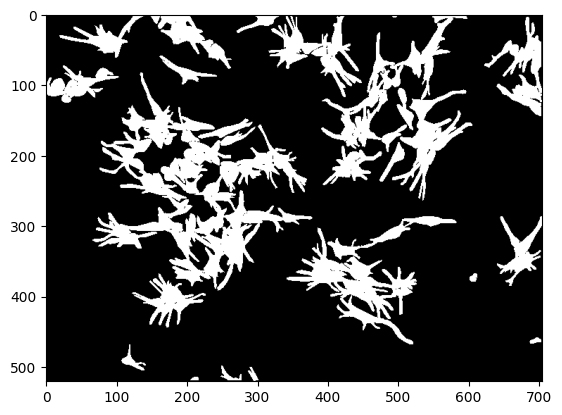

In [ ]:
shape = (521, 705, 3)
# Create a mask for corresponding image id
for image_id in image_id_to_segmentation.keys():
    combined_mask = np.zeros(shape, dtype=np.float32)
    segmentation_list = image_id_to_segmentation[image_id]['segmentation']
    for segmentation in segmentation_list:
        mask = np.zeros(shape, dtype=np.bool8)
        rr, cc = polygon(segmentation[1::2], segmentation[0::2])
        mask[rr, cc] = 1
        # combined_mask += mask
        combined_mask = np.maximum(mask, combined_mask)
    name = image_id_to_segmentation[image_id]['name']
    plt.imshow(combined_mask, cmap='gray')
    # Save mask as gray scale image
    plt.imsave(rf'dataset/train_masks/{name}.png', combined_mask, cmap='gray')
    img_pil = Image.open(rf'dataset/train_masks/{name}.png')
    img_pil = img_pil.convert('L')
    img_pil.save(os.path.join(root, rf'dataset/train_masks/{name}.png'))

In [ ]:
img = Image.open(r'D:\programming\unet-livecell-project\test_image\train_masks\A172_Phase_A7_1_00d00h00m_1.png')
img = img.convert('L')
img_arr = np.array(img)
torch.tensor(img_arr).unsqueeze(0).shape
# plt.imshow(img, cmap='gray')

torch.Size([1, 521, 705])

In [ ]:
img = Image.open(r'D:\programming\unet-livecell-project\test_image\train_images\A172_Phase_A7_1_00d00h00m_1.tif')
rgb_img = img.convert("RGB")
rgb_img.save(r'D:\programming\unet-livecell-project\test_image\train_images\A172_Phase_A7_1_00d00h00m_1.png', format="PNG")

In [ ]:
# Transform all the images to gray scale images
def transform_image(folder, save_folder, json_file):
    file_name_list = []
    for image in json_file['images']:
        file_name = image["file_name"]
        name, extension = os.path.splitext(file_name)
        file_name_list.append(name)
    print(len(file_name_list))
    for image in os.listdir(folder):
        name, extension = os.path.splitext(image)
        if name in file_name_list:
            img_path = os.path.join(folder, image)
            image = Image.open(img_path)
            image = image.convert('L')
            image.save(f'{save_folder}/{name}.png')
image_dir = r'/Users/menelaos/Desktop/U-Nets/images/livecell_train_val_images'
save_folder = r'/Users/menelaos/Desktop/U-Nets/dataset/train_images'
transform_image(image_dir, save_folder=save_folder, json_file=data)
            

3253


In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        # self.to("cuda")
        
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [11]:
model = UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
)

In [6]:
def elastic_transform(image, alpha, sigma, random_state=None):

        if random_state is None:
            random_state = np.random.RandomState(None)
    
        shape_size = image.shape[:2]
    
        # Downscaling the random grid and then upsizing post filter
        # improves performance. Approx 3x for scale of 4, diminishing returns after.
        grid_scale = 4
        alpha //= grid_scale  # Does scaling these make sense? seems to provide
        sigma //= grid_scale  # more similar end result when scaling grid used.
        grid_shape = (shape_size[0]//grid_scale, shape_size[1]//grid_scale)
    
        blur_size = int(4 * sigma) | 1
        rand_x = cv2.GaussianBlur(
            (random_state.rand(*grid_shape) * 2 - 1).astype(np.float32),
            ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
        rand_y = cv2.GaussianBlur(
            (random_state.rand(*grid_shape) * 2 - 1).astype(np.float32),
            ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
        if grid_scale > 1:
            rand_x = cv2.resize(rand_x, shape_size[::-1])
            rand_y = cv2.resize(rand_y, shape_size[::-1])
    
        grid_x, grid_y = np.meshgrid(np.arange(shape_size[1]), np.arange(shape_size[0]))
        grid_x = (grid_x + rand_x).astype(np.float32)
        grid_y = (grid_y + rand_y).astype(np.float32)
    
        distorted_img = cv2.remap(image, grid_x, grid_y,
            borderMode=cv2.BORDER_REFLECT_101, interpolation=cv2.INTER_LINEAR)
    
        return distorted_img


def augment_crop(files1, files2, dir1, dir2):
        for file1 in files1:
            for file2 in files2:
                if file1 == file2:
                    img_arr1 = cv2.imread(dir1 + file1, -1)
                    img_arr2 = cv2.imread(dir2 + file2, -1)   
    
                    img_arr2 = np.delete(img_arr2, 0, 0)
                    img_arr2 = np.delete(img_arr2, 0, 1)
    
                    im_merge = np.concatenate((img_arr1[...,None], img_arr2[...,None]), axis=2)
                    
                    #augment
                    im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 9, im_merge.shape[1] * 0.09)

                    img1_deformed = im_merge_t[...,0]
                    img2_deformed = im_merge_t[...,1]

                    #crop
                    img1_deformed = img1_deformed[50:450, 50:650]
                    img2_deformed = img2_deformed[50:450, 50:650]
                    
                    new_image = torch.tensor(img1_deformed, dtype=torch.float32).permute(2, 0, 1)
                    new_mask = torch.tensor(img2_deformed, dtype=torch.float32).unsqueeze(0)

                    return new_image, new_mask

                        

    
           

In [16]:
class CarvanaDataset():
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)
       
    def __getitem__(self):
        img_path = os.listdir(self.image_dir)
        mask_path = os.listdir(self.mask_dir)
        
        image_batch, mask_batch = augment_crop(img_path, mask_path, img_path, mask_path)
        
        return image_batch, mask_batch

In [17]:

TRAIN_IMG_DIR = r"/Users/menelaos/Desktop/U-Nets/dataset/train_images"
TRAIN_MASK_DIR = r"/Users/menelaos/Desktop/U-Nets/dataset/train_masks"
VAL_IMG_DIR = r"/Users/menelaos/Desktop/U-Nets/dataset/val_images"
VAL_MASK_DIR = r"/Users/menelaos/Desktop/U-Nets/dataset/val_masks"
TEST_IMG_DIR = r"/Users/menelaos/Desktop/U-Nets/dataset/test_images"
TEST_MASK_DIR = r"/Users/menelaos/Desktop/U-Nets/dataset/test_masks"

IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
EPOCHS = 50
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNET()
model.to(DEVICE)

train_ds = CarvanaDataset(image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR, transform= None)
val_ds = CarvanaDataset(image_dir=VAL_IMG_DIR, mask_dir=VAL_MASK_DIR, transform= None)
test_ds = CarvanaDataset(image_dir=TEST_IMG_DIR, mask_dir=TEST_MASK_DIR, transform= None)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=True)

loss_fn = DiceLoss(sigmoid=True,squared_pred=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5, amsgrad=True)

tensor([[[[0.2902, 0.3882, 0.3882,  ..., 0.0000, 0.0000, 0.0000],
          [0.3725, 0.5020, 0.5020,  ..., 0.0000, 0.0000, 0.0000],
          [0.3725, 0.5020, 0.5020,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3725, 0.5020, 0.4745,  ..., 0.4980, 0.5020, 0.5020],
          [0.3725, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.3725, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0314, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0196,  ..., 0.3961, 0.3098, 0.0980],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.2902, 0.3882, 0.3882,  ..., 0.3882, 0.3882, 0.2902],
          [0.3725, 0.4941, 0.4784,  ..., 0.5020, 0.5020, 0.3725],
          [0.3725, 0.4941, 0.4667,  ..

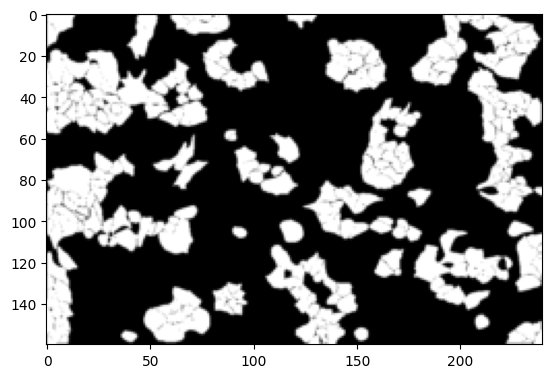

In [ ]:
(image, mask) = next(iter(val_loader))
print(mask)
plt.imshow(mask[0][0], cmap='gray')

In [ ]:
shape = (1,1,2,2)
matrix1 = torch.tensor([[[[1, 1], [1, 1]], [[2, 2], [2, 2]]]], dtype=torch.float32)
matrix2 = torch.tensor([[[[1, 1], [1, 1]], [[2, 1], [3, 5]]]], dtype=torch.float32)

print(loss_fn(matrix1, matrix2))

tensor(0.2934)


In [14]:
def compute_metric(y_pred, y_true):
    """
    y_pred: torch.Tensor, predicted segmentation mask (shape: [batch_size, num_classes, height, width])
    y_true: torch.Tensor, ground truth segmentation mask (shape: [batch_size, num_classes, height, width])
    """
    y_pred = torch.argmax(y_pred, dim=1)  # get predicted class label from logits
    correct_pixels = (y_pred == y_true).sum().item()  # count number of correctly predicted pixels
    total_pixels = y_true.numel()  # total number of pixels
    accuracy = correct_pixels / total_pixels  # calculate accuracy as fraction of correct pixels over total pixels
    return accuracy


In [18]:
train_loss_list = []
train_val_list = []
train_accuracy_list = []
val_accuracy_list = []
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
smallest_loss = 1.0
for epoch in range(EPOCHS):
    # Train
    train_epoch_loss = 0.0
    train_accuracy = 0.0
    for idx, (image, mask) in enumerate(train_loader):
        if image == '.DS_Store':
            continue
        image = image.to(device=DEVICE)
        mask = mask.to(device=DEVICE)
        optimizer.zero_grad()
        prediction = model(image)
        
        accuracy = compute_metric(prediction, mask)
        train_accuracy += accuracy
        
        loss = loss_fn(prediction, mask)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    epoch_loss = train_epoch_loss/len(train_loader)
    epoch_train_accuracy = train_accuracy/len(train_loader)
    # if (idx+1) % 10 == 0:
    print("Epoch [{}/{}], Step [{}/{}], train_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(train_loader), epoch_loss))
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_train_accuracy)
    # Val
    with torch.no_grad():
        val_loss = 0.0
        val_accuracy = 0.0
        for idx, (image, mask) in enumerate(val_loader):
            image = image.to(device=DEVICE)
            mask = mask.to(device=DEVICE)
            prediction = model(image)
            
            accuracy = compute_metric(prediction, mask)
            val_accuracy += accuracy
            
            loss = loss_fn(prediction, mask)
            val_loss += loss.item()
        epoch_loss = val_loss/len(val_loader)
        epoch_val_accuracy = val_accuracy/len(val_loader)
        if (idx+1) % 10 == 0:
            print("Epoch [{}/{}], Step [{}/{}], val_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(val_loader), epoch_loss))
        if epoch_loss < smallest_loss:
            smallest_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        train_val_list.append(epoch_loss)
        val_accuracy_list.append(epoch_val_accuracy)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
print('Smallest val loss: {:4f}'.format(smallest_loss))

[ WARN:0@183.409] global loadsave.cpp:244 findDecoder imread_('/Users/menelaos/Desktop/U-Nets/dataset/train_images/SkBr3_Phase_H3_2_01d00h00m_3.png/'): can't open/read file: check file path/integrity
[ WARN:0@183.411] global loadsave.cpp:244 findDecoder imread_('/Users/menelaos/Desktop/U-Nets/dataset/train_masks/SkBr3_Phase_H3_2_01d00h00m_3.png/'): can't open/read file: check file path/integrity


AxisError: axis 0 is out of bounds for array of dimension 0

In [ ]:
torch.save(best_model_wts, 'model/best_model.pth')

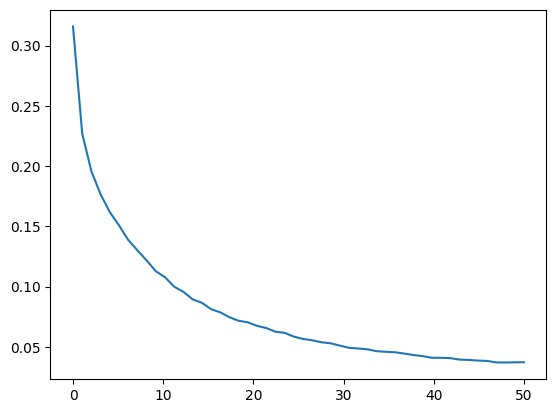

In [ ]:
x = np.linspace(0, EPOCHS, EPOCHS)
plt.plot(x, train_loss_list)

In [ ]:
model = UNET()
state_dict = torch.load('model/model1.pth')
model.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
DEVICE='cuda' if torch.cuda.is_available() else "cpu"
model.to(DEVICE)
model.eval()
input, mask = next(iter(test_loader))
image = input[1].unsqueeze(0)
image = image.to(DEVICE)
mask = mask.to(DEVICE)
preds = torch.sigmoid(model(image))
preds = (preds > 0.5).float()
print(loss_fn(preds, mask[1].unsqueeze(0)))
preds = preds.cpu()
preds = preds.squeeze(0).squeeze(0)
mask = mask[1].squeeze(0).cpu()
fig, ax = plt.subplots(1, 2, figsize=(30,60))
ax[0].imshow(preds, cmap='gray')
ax[1].imshow(mask, cmap='gray')


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
model.to(DEVICE)
model.eval()
input, mask = next(iter(test_loader))
image = input[1].unsqueeze(0)
image = image.to(DEVICE)
mask = mask.to(DEVICE)
preds = torch.sigmoid(model(image))
preds = (preds > 0.5).float()
loss_fn(preds, mask[1].unsqueeze(0))

IndexError: index 1 is out of bounds for dimension 0 with size 1